# Satellite Imagery Analysis for Finance

## 1. Setup and Import Libraries

In [22]:
!pip install linearmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS
import warnings


pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Generate Synthetic Satellite and Financial Data


In [23]:

np.random.seed(42)


regions = ['North America', 'Europe', 'Asia', 'Latin America', 'Africa']
n_regions = len(regions)
n_quarters = 40
dates = pd.date_range(start='2015-01-01', periods=n_quarters, freq='Q')


data_list = []
for region in regions:
    region_base_light = np.random.uniform(50, 100)
    region_base_vehicles = np.random.uniform(1000, 5000)
    region_base_port = np.random.uniform(20, 80)
    region_growth_trend = np.random.uniform(-0.2, 0.5)

    for i, date in enumerate(dates):
        time_trend = i / n_quarters
        macro_shock = np.sin(2 * np.pi * i / 8) * 5

        light_intensity = (region_base_light +
                          region_growth_trend * time_trend * 50 +
                          macro_shock +
                          np.random.normal(0, 5))

        vehicle_count = (region_base_vehicles +
                        0.3 * light_intensity +
                        np.random.normal(0, 200))

        port_congestion = (region_base_port +
                          0.2 * light_intensity +
                          macro_shock * 2 +
                          np.random.normal(0, 8))

        gdp_growth = (1.5 +
                     0.03 * (light_intensity - region_base_light) +
                     0.02 * macro_shock +
                     np.random.normal(0, 1.5))

        stock_return = (5 +
                       0.5 * gdp_growth +
                       0.02 * (light_intensity - region_base_light) +
                       np.random.normal(0, 3))

        data_list.append({
            'region': region,
            'date': date,
            'light_intensity': light_intensity,
            'vehicle_count': vehicle_count,
            'port_congestion': port_congestion,
            'gdp_growth': gdp_growth,
            'stock_return': stock_return
        })

df = pd.DataFrame(data_list)

print(f"Generated dataset with {len(df)} observations")
print(f"Regions: {n_regions}, Time periods: {n_quarters}")
df.head(10)

Generated dataset with 200 observations
Regions: 5, Time periods: 40


,region,date,light_intensity,vehicle_count,port_congestion,gdp_growth,stock_return
0,North America,2015-03-31,67.5562,4776.2967,90.0646,2.6160,4.8762
1,North America,2015-06-30,75.2492,4732.7484,82.3147,2.1293,0.4553
2,North America,2015-09-30,65.6501,4710.0947,78.9470,1.9791,3.2039
3,North America,2015-12-31,66.0225,5115.7937,82.3890,1.5909,1.4671
4,North America,2016-03-31,67.1004,4845.1719,68.1318,2.0147,4.1729
5,North America,2016-06-30,65.1021,4702.0465,84.6872,1.3003,2.4045
6,North America,2016-09-30,69.4827,4579.5333,69.4871,-1.5168,0.2721
7,North America,2016-12-31,68.0926,4970.9783,71.8380,1.2368,4.7024
8,North America,2017-03-31,63.5250,4677.9459,72.9395,2.9296,7.3916
9,North America,2017-06-30,65.9118,4887.4476,81.0924,0.4709,7.0142


## 3. Data Structure and Summary Statistics

In [24]:
print("Dataset Information:")
print(df.info())


# Summary statistics
print("Summary Statistics:")
summary_stats = df.describe()
summary_stats

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   region           200 non-null    object        
 1   date             200 non-null    datetime64[ns]
 2   light_intensity  200 non-null    float64       
 3   vehicle_count    200 non-null    float64       
 4   port_congestion  200 non-null    float64       
 5   gdp_growth       200 non-null    float64       
 6   stock_return     200 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 11.1+ KB
None
Summary Statistics:


,date,light_intensity,vehicle_count,port_congestion,gdp_growth,stock_return
count,200,200.0000,200.0000,200.0000,200.0000,200.0000
mean,2020-02-14 06:00:00,81.2486,3505.1937,66.1672,1.7075,5.8514
min,2015-03-31 00:00:00,40.8933,1894.7340,27.8726,-1.7434,-3.5552
25%,2017-09-07 00:00:00,68.0066,3214.8944,54.7984,0.6148,3.8888
50%,2020-02-14 12:00:00,79.8101,3477.3090,64.9762,1.7320,5.7197
75%,2022-07-23 00:00:00,93.2124,3752.3987,78.6557,2.6822,7.6753
max,2024-12-31 00:00:00,117.3496,5264.4183,111.3720,5.4121,13.7181
std,NaN,15.8057,847.7699,16.0548,1.4810,3.1492


In [25]:
print("Summary Statistics by Region (Light Intensity):")
df.groupby('region')['light_intensity'].describe()

Summary Statistics by Region (Light Intensity):


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Africa,40.0,90.5993,7.0351,74.5104,86.2808,91.5026,95.2788,104.7560
Asia,40.0,102.3860,7.7455,84.3918,97.4848,102.1648,108.0043,117.3496
Europe,40.0,78.1709,8.2187,62.4187,71.4580,79.6888,83.1796,99.5244
Latin America,40.0,62.1428,6.3386,40.8933,59.7706,62.9656,64.3345,76.5279
North America,40.0,72.9441,7.3988,54.4618,67.7007,74.0594,77.0890,95.4473


## 4. Exploratory Data Analysis (EDA)

### 4.1 Time Series Visualization

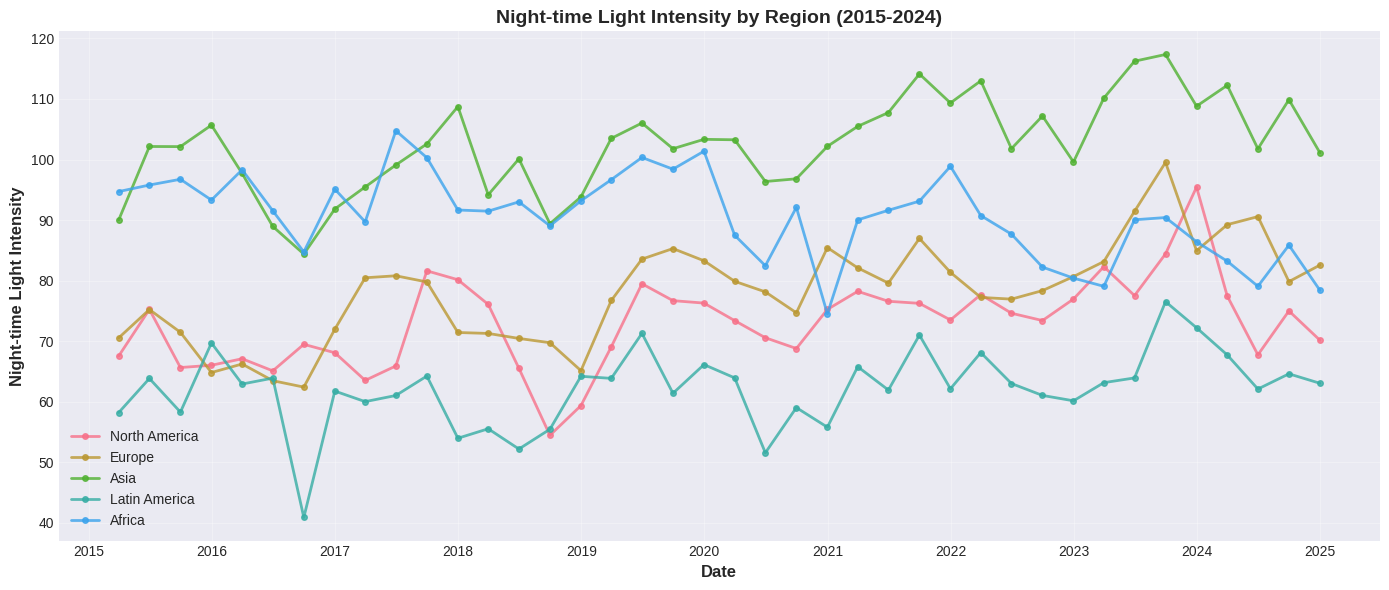

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))

for region in regions:
    region_data = df[df['region'] == region]
    ax.plot(region_data['date'], region_data['light_intensity'],
            marker='o', linewidth=2, markersize=4, label=region, alpha=0.8)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Night-time Light Intensity', fontsize=12, fontweight='bold')
ax.set_title('Night-time Light Intensity by Region (2015-2024)',
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

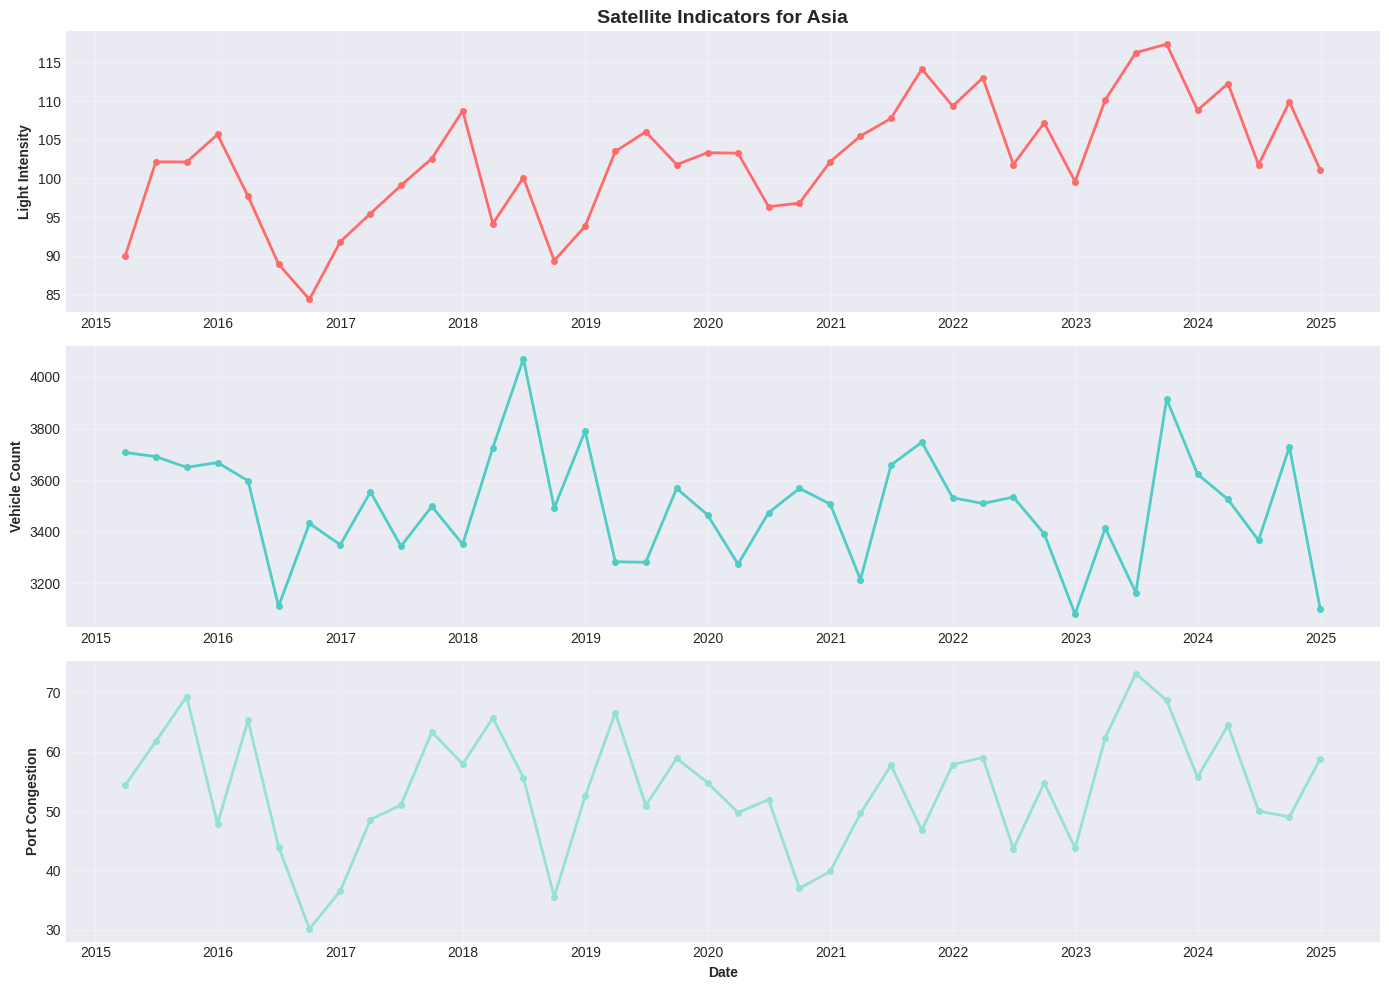

In [27]:
sample_region = 'Asia'
region_df = df[df['region'] == sample_region].copy()

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Light intensity
axes[0].plot(region_df['date'], region_df['light_intensity'],
             color='#FF6B6B', linewidth=2, marker='o', markersize=4)
axes[0].set_ylabel('Light Intensity', fontweight='bold')
axes[0].set_title(f'Satellite Indicators for {sample_region}',
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Vehicle count
axes[1].plot(region_df['date'], region_df['vehicle_count'],
             color='#4ECDC4', linewidth=2, marker='o', markersize=4)
axes[1].set_ylabel('Vehicle Count', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Port congestion
axes[2].plot(region_df['date'], region_df['port_congestion'],
             color='#95E1D3', linewidth=2, marker='o', markersize=4)
axes[2].set_ylabel('Port Congestion', fontweight='bold')
axes[2].set_xlabel('Date', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Distribution Analysis

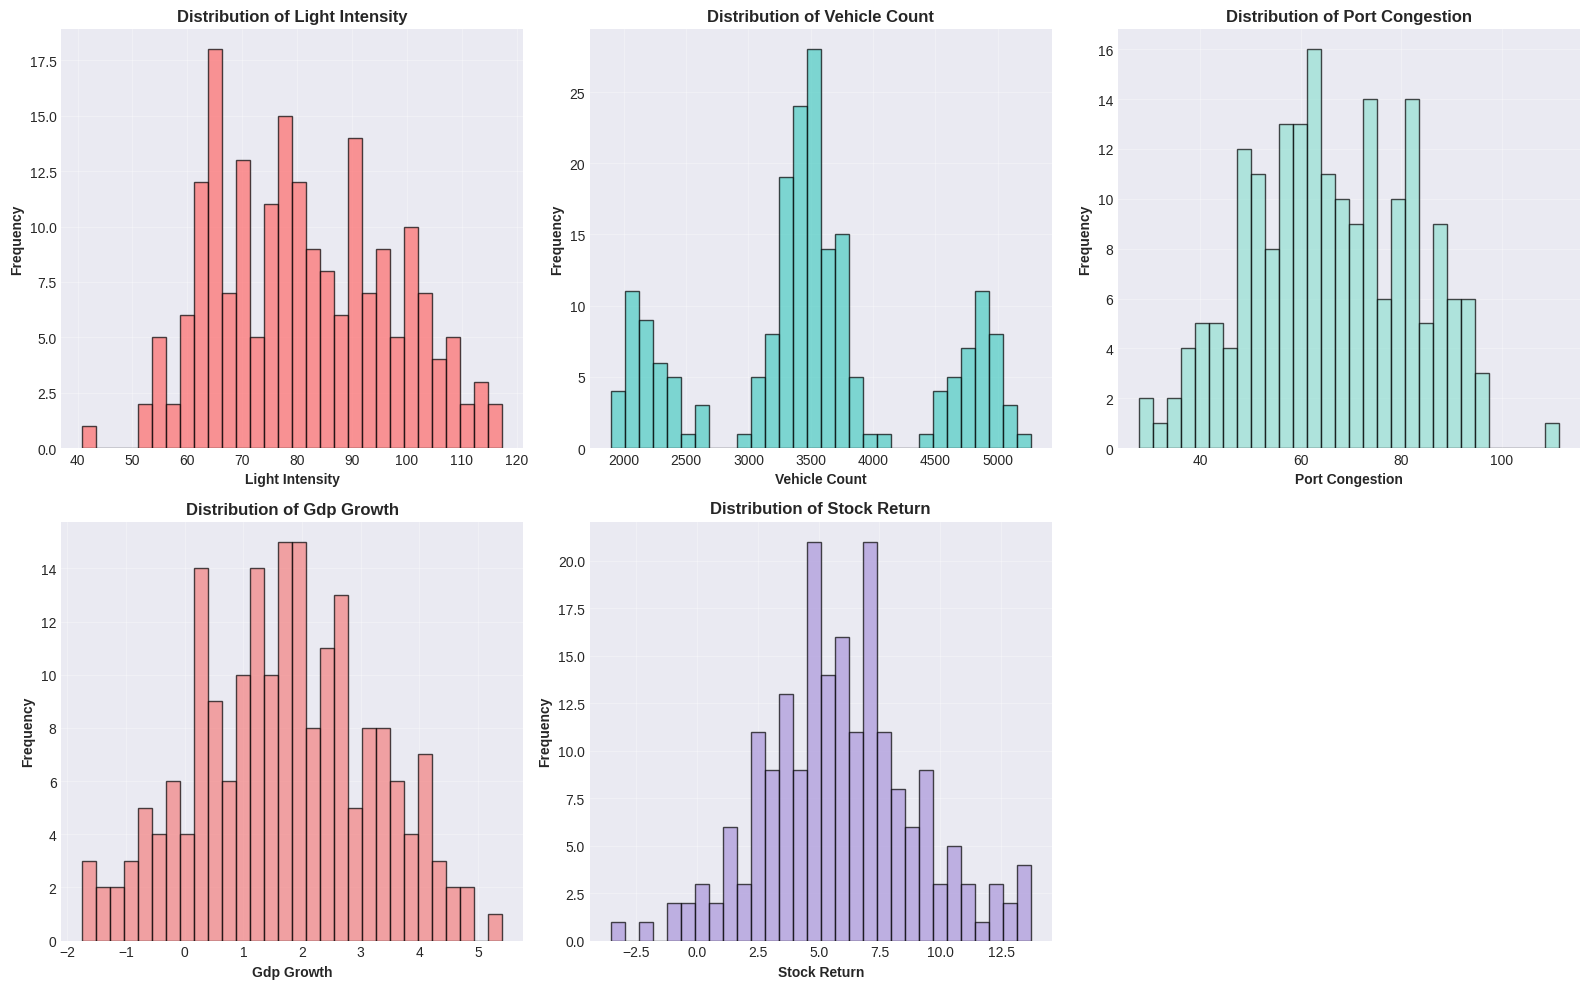

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

variables = ['light_intensity', 'vehicle_count', 'port_congestion',
             'gdp_growth', 'stock_return']
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181', '#AA96DA']

for idx, (var, color) in enumerate(zip(variables, colors)):
    axes[idx].hist(df[var], bins=30, color=color, alpha=0.7, edgecolor='black')
    axes[idx].set_xlabel(var.replace('_', ' ').title(), fontweight='bold')
    axes[idx].set_ylabel('Frequency', fontweight='bold')
    axes[idx].set_title(f'Distribution of {var.replace("_", " ").title()}',
                       fontweight='bold')
    axes[idx].grid(True, alpha=0.3)


fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 5. Correlation Analysis

Examining relationships between satellite indicators and traditional financial/economic variables.

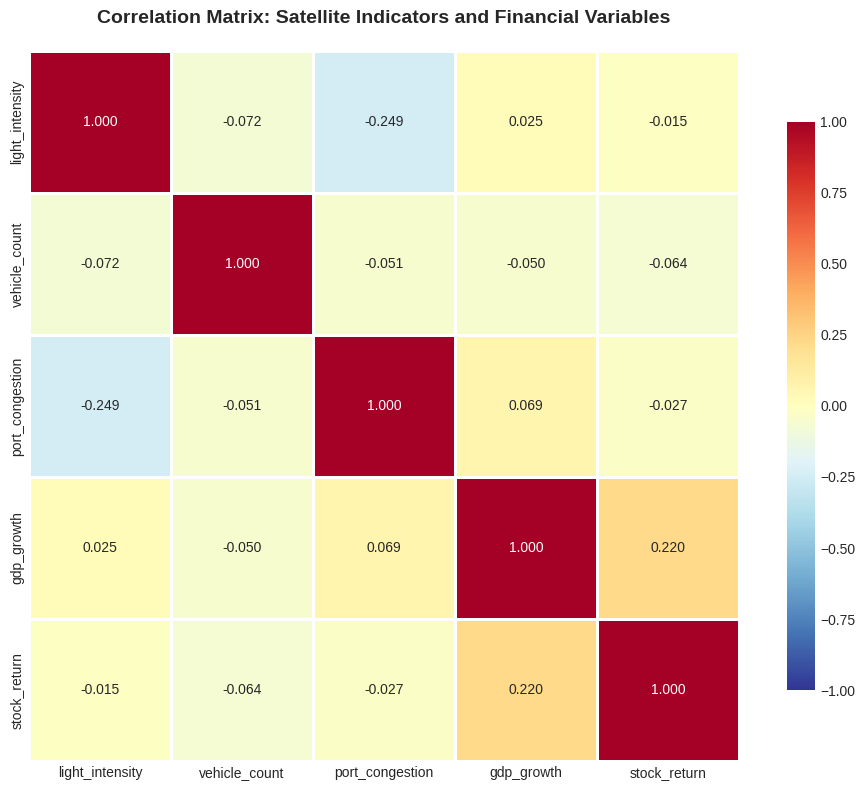


Correlation Matrix:
                 light_intensity  vehicle_count  port_congestion  gdp_growth  \
light_intensity           1.0000        -0.0717          -0.2494      0.0245   
vehicle_count            -0.0717         1.0000          -0.0512     -0.0504   
port_congestion          -0.2494        -0.0512           1.0000      0.0687   
gdp_growth                0.0245        -0.0504           0.0687      1.0000   
stock_return             -0.0148        -0.0640          -0.0267      0.2197   

                 stock_return  
light_intensity       -0.0148  
vehicle_count         -0.0640  
port_congestion       -0.0267  
gdp_growth             0.2197  
stock_return           1.0000  


In [29]:

correlation_vars = ['light_intensity', 'vehicle_count', 'port_congestion',
                   'gdp_growth', 'stock_return']
corr_matrix = df[correlation_vars].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation Matrix: Satellite Indicators and Financial Variables',
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(corr_matrix)

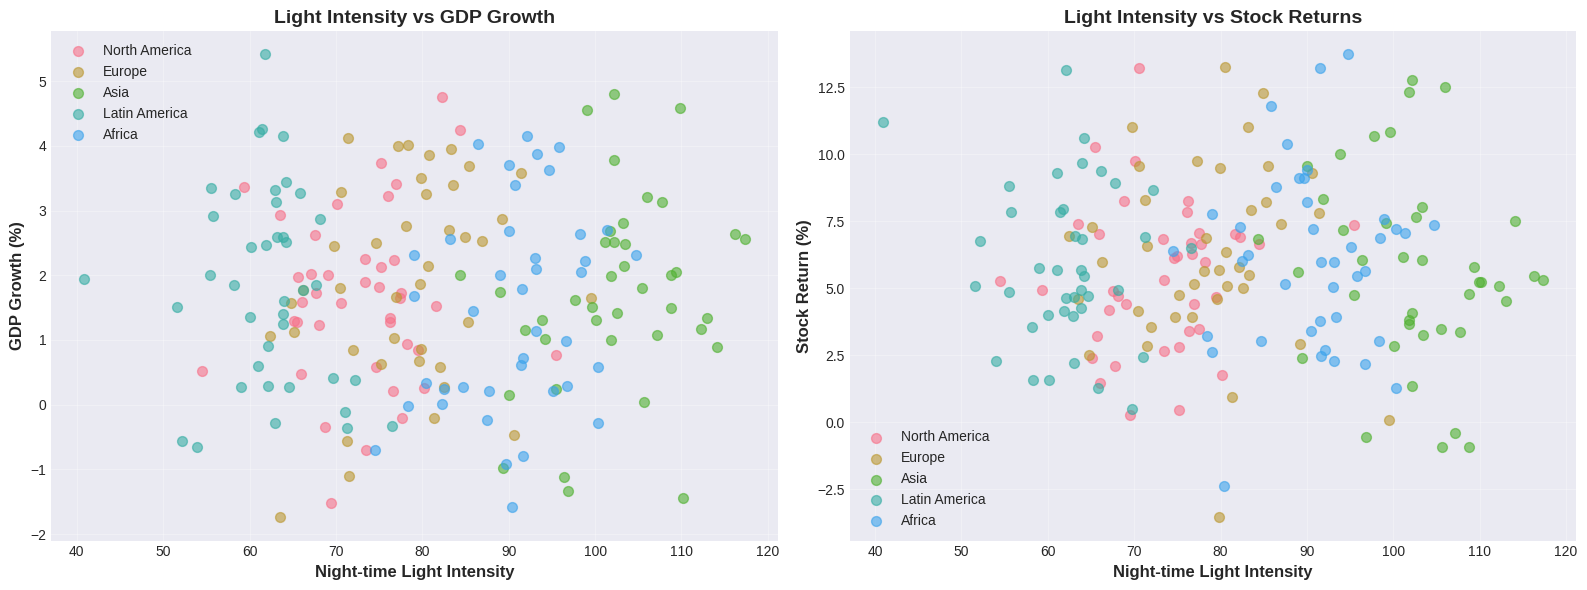

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for region in regions:
    region_data = df[df['region'] == region]
    axes[0].scatter(region_data['light_intensity'], region_data['gdp_growth'],
                   label=region, alpha=0.6, s=50)

axes[0].set_xlabel('Night-time Light Intensity', fontsize=12, fontweight='bold')
axes[0].set_ylabel('GDP Growth (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Light Intensity vs GDP Growth', fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)


for region in regions:
    region_data = df[df['region'] == region]
    axes[1].scatter(region_data['light_intensity'], region_data['stock_return'],
                   label=region, alpha=0.6, s=50)

axes[1].set_xlabel('Night-time Light Intensity', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Stock Return (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Light Intensity vs Stock Returns', fontsize=14, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Principal Component Analysis (PCA)

Extracting latent economic factors from multiple satellite indicators.

In [31]:

satellite_features = ['light_intensity', 'vehicle_count', 'port_congestion']
X = df[satellite_features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
principal_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=principal_components,
                      columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
pca_df['region'] = df['region'].values
pca_df['date'] = df['date'].values

print("PCA Results:")
print(f"Number of components: {pca.n_components_}")
print(f"\nExplained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")
print(f"\nCumulative explained variance: {pca.explained_variance_ratio_.sum():.4f}")

PCA Results:
Number of components: 3

Explained variance ratio:
  PC1: 0.4168 (41.68%)
  PC2: 0.3421 (34.21%)
  PC3: 0.2411 (24.11%)

Cumulative explained variance: 1.0000


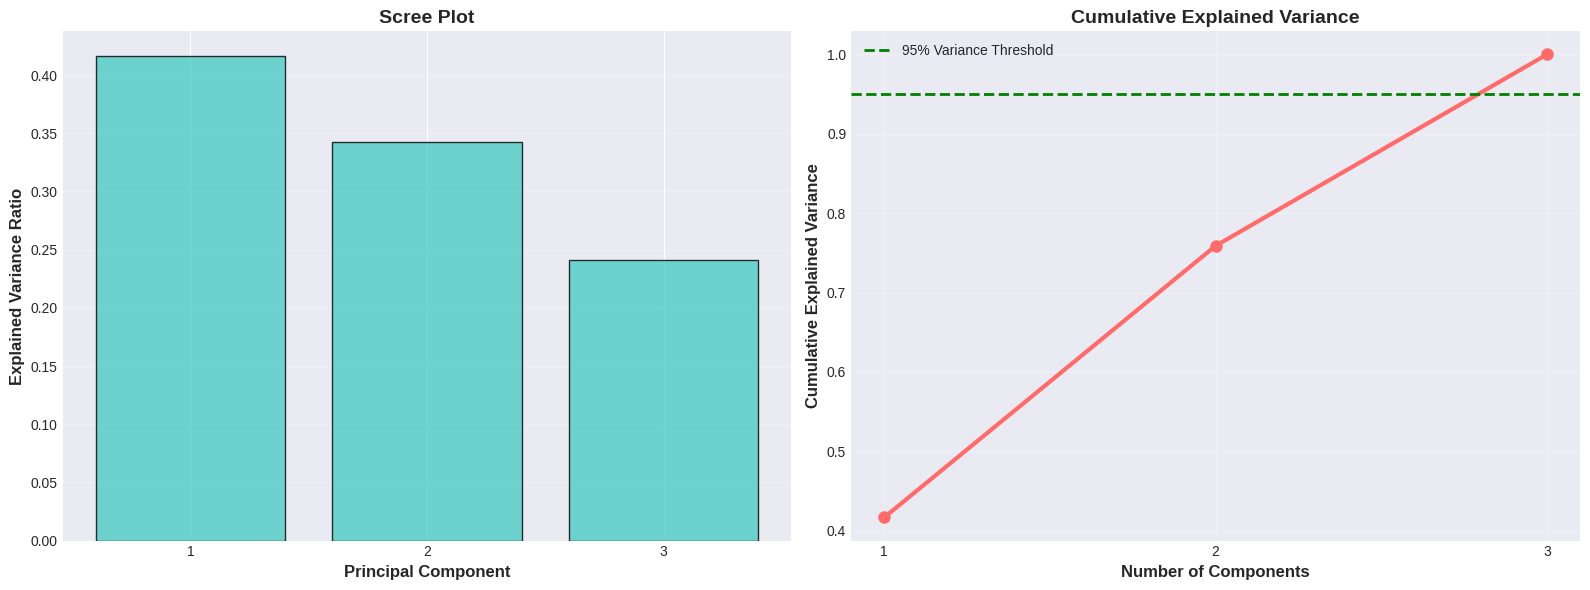

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1),
           pca.explained_variance_ratio_, color='#4ECDC4', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('Scree Plot', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, len(pca.explained_variance_ratio_) + 1))
axes[0].grid(True, alpha=0.3, axis='y')
cumsum = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, len(cumsum) + 1), cumsum,
            marker='o', linewidth=3, markersize=8, color='#FF6B6B')
axes[1].axhline(y=0.95, color='green', linestyle='--', linewidth=2,
               label='95% Variance Threshold')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, len(cumsum) + 1))
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Principal Component Loadings:
                    PC1     PC2     PC3
light_intensity  0.7133 -0.1683  0.6804
vehicle_count   -0.0616  0.9519  0.3000
port_congestion -0.6981 -0.2559  0.6687


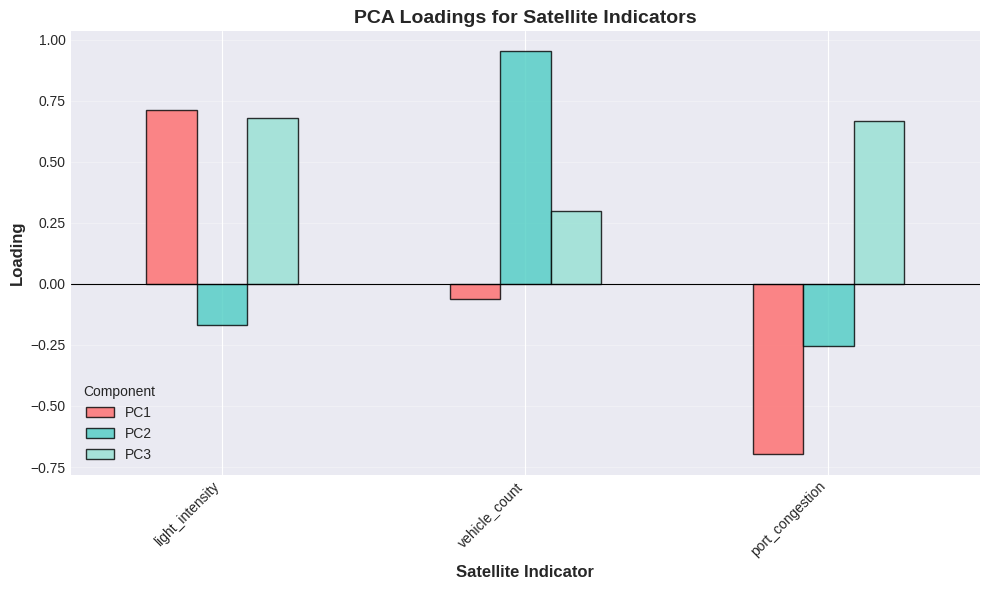

In [33]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=satellite_features
)

print("\nPrincipal Component Loadings:")
print(loadings)

fig, ax = plt.subplots(figsize=(10, 6))
loadings.plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4', '#95E1D3'],
              edgecolor='black', alpha=0.8)
ax.set_xlabel('Satellite Indicator', fontsize=12, fontweight='bold')
ax.set_ylabel('Loading', fontsize=12, fontweight='bold')
ax.set_title('PCA Loadings for Satellite Indicators', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.legend(title='Component', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

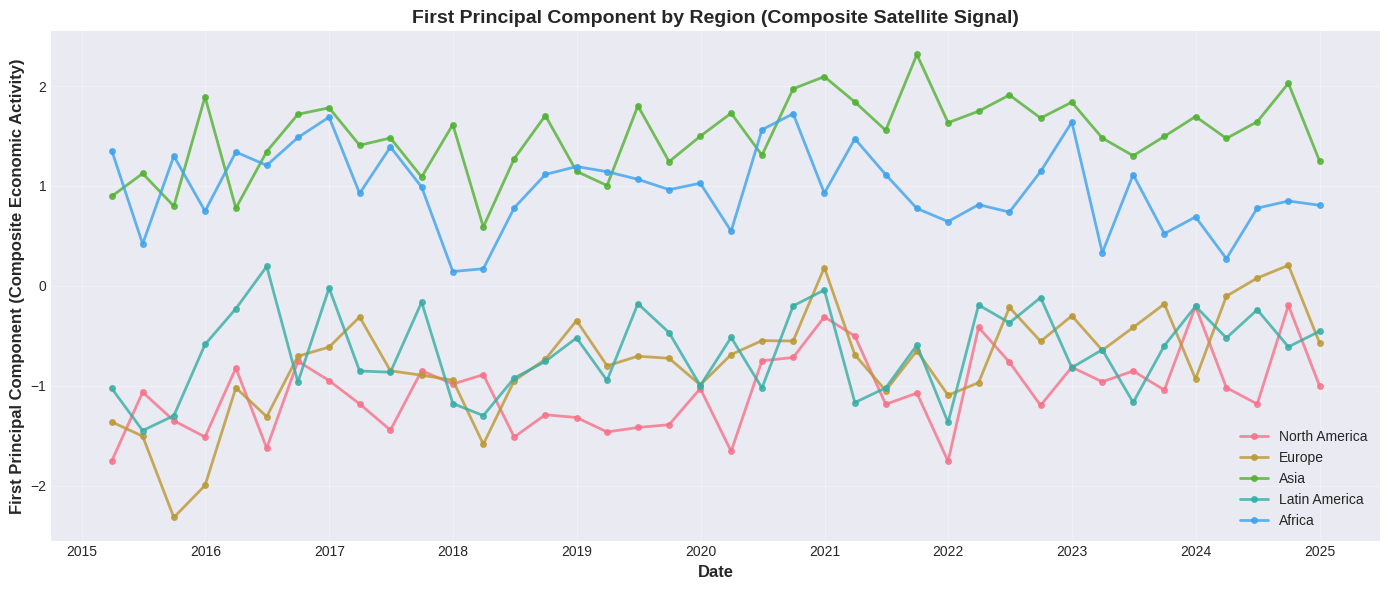

In [34]:
fig, ax = plt.subplots(figsize=(14, 6))

for region in regions:
    region_pca = pca_df[pca_df['region'] == region]
    ax.plot(region_pca['date'], region_pca['PC1'],
            marker='o', linewidth=2, markersize=4, label=region, alpha=0.8)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('First Principal Component (Composite Economic Activity)',
             fontsize=12, fontweight='bold')
ax.set_title('First Principal Component by Region (Composite Satellite Signal)',
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Panel Regression Analysis

### 7.1 Pooled OLS (Baseline)

In [35]:
panel_df = df.set_index(['region', 'date'])
from sklearn.linear_model import LinearRegression
from scipy import stats

X_pooled = df[['light_intensity']].values
y_pooled = df['gdp_growth'].values

pooled_model = LinearRegression()
pooled_model.fit(X_pooled, y_pooled)

y_pred = pooled_model.predict(X_pooled)
residuals = y_pooled - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_pooled - np.mean(y_pooled))**2)
r_squared = 1 - (ss_res / ss_tot)


print("POOLED OLS REGRESSION")
print(f"Dependent Variable: GDP Growth")
print(f"Independent Variable: Light Intensity")
print(f"\nCoefficient: {pooled_model.coef_[0]:.4f}")
print(f"Intercept: {pooled_model.intercept_:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"Number of observations: {len(y_pooled)}")


POOLED OLS REGRESSION
Dependent Variable: GDP Growth
Independent Variable: Light Intensity

Coefficient: 0.0023
Intercept: 1.5208
R-squared: 0.0006
Number of observations: 200


### 7.2 Fixed Effects Panel Regression

Controlling for region-specific (entity) and time-specific effects.

In [36]:

print("ENTITY FIXED EFFECTS REGRESSION (Region FE)")


# Dependent and independent variables
y_panel = panel_df['gdp_growth']
X_panel = panel_df[['light_intensity']]

# Entity fixed effects model
entity_fe = PanelOLS(y_panel, X_panel, entity_effects=True)
entity_fe_results = entity_fe.fit(cov_type='clustered', cluster_entity=True)

print(entity_fe_results)

ENTITY FIXED EFFECTS REGRESSION (Region FE)
                          PanelOLS Estimation Summary                           
Dep. Variable:             gdp_growth   R-squared:                        0.0219
Estimator:                   PanelOLS   R-squared (Between):              0.7355
No. Observations:                 200   R-squared (Within):               0.0219
Date:                Tue, Feb 03 2026   R-squared (Overall):              0.4333
Time:                        22:17:14   Log-likelihood                   -358.55
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.3492
Entities:                           5   P-value                           0.0383
Avg Obs:                       40.000   Distribution:                   F(1,194)
Min Obs:                       40.000                                           
Max Obs:                       40.000   F-statistic (robust):    

In [37]:

print("TIME FIXED EFFECTS REGRESSION")


time_fe = PanelOLS(y_panel, X_panel, time_effects=True)
time_fe_results = time_fe.fit(cov_type='clustered', cluster_time=True)

print(time_fe_results)

TIME FIXED EFFECTS REGRESSION
                          PanelOLS Estimation Summary                           
Dep. Variable:             gdp_growth   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.1219
No. Observations:                 200   R-squared (Within):              -0.0019
Date:                Tue, Feb 03 2026   R-squared (Overall):             -0.0711
Time:                        22:17:14   Log-likelihood                   -347.30
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0300
Entities:                           5   P-value                           0.8628
Avg Obs:                       40.000   Distribution:                   F(1,159)
Min Obs:                       40.000                                           
Max Obs:                       40.000   F-statistic (robust):             0.033

In [38]:

print("TWO-WAY FIXED EFFECTS REGRESSION (Region FE + Time FE)")


twoway_fe = PanelOLS(y_panel, X_panel, entity_effects=True, time_effects=True)
twoway_fe_results = twoway_fe.fit(cov_type='clustered', cluster_entity=True)

print(twoway_fe_results)

TWO-WAY FIXED EFFECTS REGRESSION (Region FE + Time FE)
                          PanelOLS Estimation Summary                           
Dep. Variable:             gdp_growth   R-squared:                        0.0102
Estimator:                   PanelOLS   R-squared (Between):              0.8740
No. Observations:                 200   R-squared (Within):               0.0216
Date:                Tue, Feb 03 2026   R-squared (Overall):              0.5129
Time:                        22:17:14   Log-likelihood                   -345.06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.5956
Entities:                           5   P-value                           0.2084
Avg Obs:                       40.000   Distribution:                   F(1,155)
Min Obs:                       40.000                                           
Max Obs:                       40.000   F-statistic (r

### 7.3 Multiple Satellite Indicators Regression

In [39]:

print("TWO-WAY FE: MULTIPLE SATELLITE INDICATORS")


X_multi = panel_df[['light_intensity', 'vehicle_count', 'port_congestion']]

multi_fe = PanelOLS(y_panel, X_multi, entity_effects=True, time_effects=True)
multi_fe_results = multi_fe.fit(cov_type='clustered', cluster_entity=True)

print(multi_fe_results)

TWO-WAY FE: MULTIPLE SATELLITE INDICATORS
                          PanelOLS Estimation Summary                           
Dep. Variable:             gdp_growth   R-squared:                        0.0119
Estimator:                   PanelOLS   R-squared (Between):              0.8963
No. Observations:                 200   R-squared (Within):               0.0192
Date:                Tue, Feb 03 2026   R-squared (Overall):              0.5248
Time:                        22:17:14   Log-likelihood                   -344.89
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.6129
Entities:                           5   P-value                           0.6076
Avg Obs:                       40.000   Distribution:                   F(3,153)
Min Obs:                       40.000                                           
Max Obs:                       40.000   F-statistic (robust):      

In [41]:

comparison_df = pd.DataFrame({
    'Model': ['Pooled OLS', 'Entity FE', 'Time FE', 'Two-Way FE', 'Multi Two-Way FE'],
    'R-squared': [
        r_squared,
        entity_fe_results.rsquared,
        time_fe_results.rsquared,
        twoway_fe_results.rsquared,
        multi_fe_results.rsquared
    ],
    'Light Coef': [
        pooled_model.coef_[0],
        entity_fe_results.params['light_intensity'],
        time_fe_results.params['light_intensity'],
        twoway_fe_results.params['light_intensity'],
        multi_fe_results.params['light_intensity']
    ],
    'Observations': [
        len(y_pooled),
        entity_fe_results.nobs,
        time_fe_results.nobs,
        twoway_fe_results.nobs,
        multi_fe_results.nobs
    ]
})


print("MODEL COMPARISON")

print(comparison_df.to_string(index=False))


MODEL COMPARISON
           Model  R-squared  Light Coef  Observations
      Pooled OLS     0.0006      0.0023           200
       Entity FE     0.0219      0.0299           200
         Time FE     0.0002     -0.0013           200
      Two-Way FE     0.0102      0.0260           200
Multi Two-Way FE     0.0119      0.0274           200


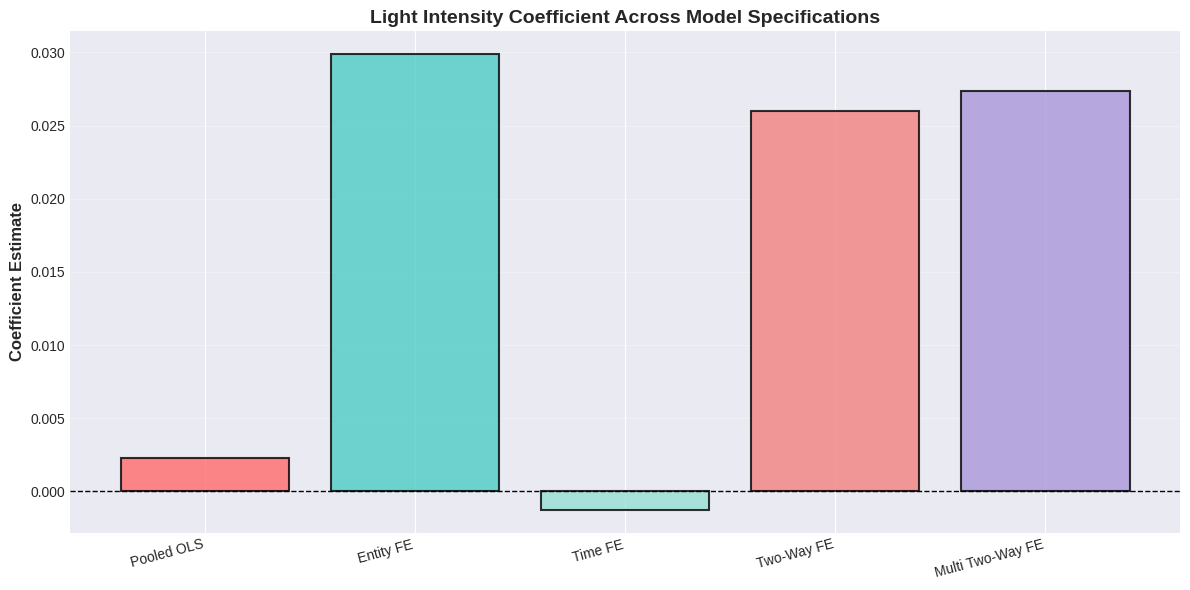

In [42]:
# Visualize coefficient estimates across models
fig, ax = plt.subplots(figsize=(12, 6))

models = comparison_df['Model'].values
coefficients = comparison_df['Light Coef'].values

colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181', '#AA96DA']
bars = ax.bar(models, coefficients, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Coefficient Estimate', fontsize=12, fontweight='bold')
ax.set_title('Light Intensity Coefficient Across Model Specifications',
             fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## 8. Predictive Analysis: Stock Returns

Using satellite indicators to predict stock returns.

In [43]:
print("PREDICTING STOCK RETURNS WITH SATELLITE DATA")

y_stock = panel_df['stock_return']
X_stock = panel_df[['light_intensity', 'vehicle_count', 'port_congestion']]

stock_fe = PanelOLS(y_stock, X_stock, entity_effects=True, time_effects=True)
stock_fe_results = stock_fe.fit(cov_type='clustered', cluster_entity=True)

print(stock_fe_results)

PREDICTING STOCK RETURNS WITH SATELLITE DATA
                          PanelOLS Estimation Summary                           
Dep. Variable:           stock_return   R-squared:                        0.0038
Estimator:                   PanelOLS   R-squared (Between):             -1.4627
No. Observations:                 200   R-squared (Within):              -0.0009
Date:                Tue, Feb 03 2026   R-squared (Overall):             -1.1379
Time:                        22:17:55   Log-likelihood                   -485.09
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.1954
Entities:                           5   P-value                           0.8994
Avg Obs:                       40.000   Distribution:                   F(3,153)
Min Obs:                       40.000                                           
Max Obs:                       40.000   F-statistic (robust):   